## TV in-painting

You are given an $m \times n$ corrupted image 

$$X\in \mathbb{R}^{m\times n}$$ 

some of whose pixel values are missing. 
The missing pixels can be located from the $m\times n$ binary matrix 

$$B\in\mathbb{B}^{m\times n}$$

where $B_{ij}=1$ if $X_{ij}$ is known, and $B_{ij}=0$ if $X_{ij}$ is unknown.

Your job is to reconstruct, by using $X$ and $B$, the corrupted image by filling appropriate pixel values 
into the unknown pixels where $B_{ij}=0$, so that your reconstructed image looks natural.



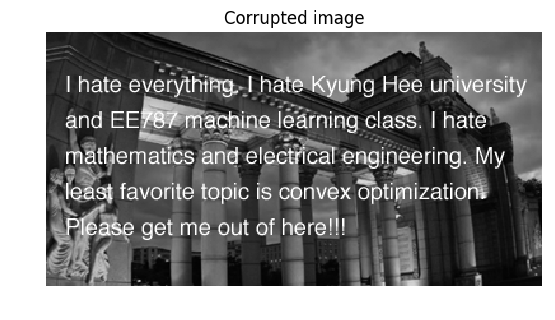

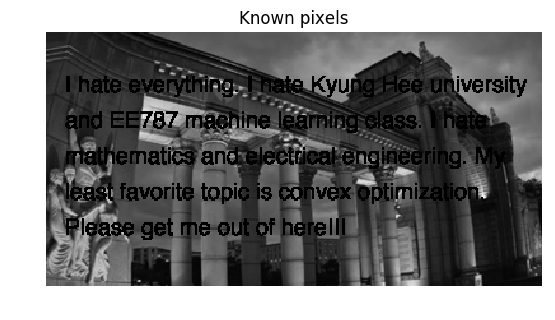

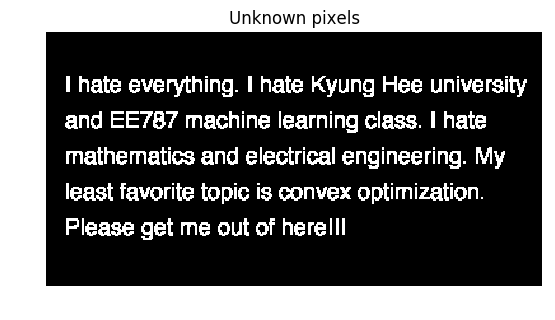

In [8]:
using PyPlot 

include("../readclassjson.jl");

all_data = readclassjson("corrupted_image.json");
m = all_data["m"];
n = all_data["n"];
X = all_data["X"]';     
B = all_data["B"]';     

figure();
imshow(X, cmap="gray");
axis("off");
title("Corrupted image");

figure();
imshow(B.*X, cmap="gray");
axis("off");
title("Known pixels")
figure();
imshow(1-B, cmap="gray");
axis("off");
title("Unknown pixels");

Let $n_\text{known}$ be the number of known pixels and $n_\text{unknown}$ be the number of unknown pixels, so $mn = n_\text{known} + n_\text{unknown}$.

You will define 

\begin{align*}
Z_\text{known}&\in\mathbb{R}^{mn \times n_\text{known}} \\
x_\text{known}&\in\mathbb{R}^{n_\text{known}} \\
Z_\text{unknown}&\in\mathbb{R}^{mn \times n_\text{unknown}} \\
x_\text{unknown}&\in\mathbb{R}^{n_\text{unknown}} 
\end{align*}

so that

$$\text{vec}(X_\text{recon}) = Z_\text{known}x_\text{known} + Z_\text{unknown}x_\text{unknown}$$

where $x_\text{known}$ is $n_\text{known}$-vector containing the known pixel values, and $x_\text{unknown}$ is $n_\text{unknown}$-vector of unknown pixel values, that we will have to find.
For example, the known part of the corrupted image can be formed from

$$ \text{vec}^{-1}(Z_\text{known}x_\text{known}) $$

Note that the reconstructed image $X_\text{recon}$ is a simple linear function of the unknown variable $x_\text{unknown}$, and the inpainting problem boiils down to finding good $x_\text{unknown}$. Once you have it, the reconstructed image can be obtained from

$$\text{vec}^{-1} ( Z_\text{known}x_\text{known} + Z_\text{unknown}x_\text{unknown} ) $$




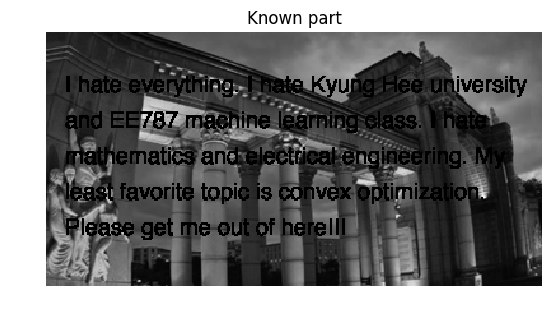

PyObject Text(0.5,1,'Known part')

In [9]:
n_total = m*n;
n_known = sum(B);
n_unknown = n_total - n_known;

V_known = B[:];
V_unknown = 1-B[:];

Z_known = sparse(1:n_known,find(V_known -> V_known>0, V_known),Int8.(ones(n_known)));
Z_unknown = sparse(1:n_unknown,find(V_unknown -> V_unknown>0, V_unknown),Int8.(ones(n_unknown)));
Z_unknown = [Z_unknown spzeros(n_unknown, n_total-size(Z_unknown,2))];
Z_known = Z_known';
Z_unknown = Z_unknown';
x_known = Z_known'*X[:];     

figure();
imshow(reshape(Z_known*x_known, m, n), cmap="gray");
axis("off");
title("Known part")

We define a function that quantifies the "naturalness" of rectangular images.

$$
\text{TV}(X) = \sum_{i}^{m-1}\sum_{j}^{n-1} \left(  |X_{ij}-X_{i+1,j}|^p + |X_{ij}-X_{i,j+1}|^p \right) 
$$

Note that this can be written as follows by some $D_x\in\mathbb{R}^{(m-1)n\times mn}$ and $D_y\in\mathbb{R}^{m(n-1)\times mn}$

$$
\text{TV}(X) = \left\| \begin{bmatrix}{D_x \\ D_y}\end{bmatrix} \text{vec}(X) \right\|_p^p 
$$



In [14]:
m*n, n_known, n_unknown

(78000, 68874, 9126)

In [15]:
Dx = [spzeros(m*(n-1),m) speye(m*(n-1))] - [speye(m*(n-1)) spzeros(m*(n-1),m)];
Dy = kron(speye(n), diff(speye(m)));

A_MATRIX = [Dx; Dy]*Z_unknown;
B_MATRIX = [Dx; Dy]*Z_known*x_known;

Now the inpainting problem is finding $x_\text{unknown}$ that minimizes $\text{TV}(X_\text{recon})$, in other words, 

$$
\text{minimize}_{x_\text{unknown}}\quad \left\| \begin{bmatrix}{D_x \\ D_y}\end{bmatrix} \Big( Z_\text{known}x_\text{known} + Z_\text{unknown}x_\text{unknown} \Big)  \right\|_p
$$

First, the 2-norm reconstruction via ordinary least squares solution.

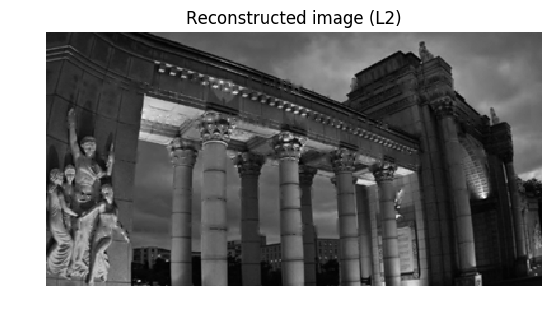

In [16]:
x_unknown = - A_MATRIX \ B_MATRIX;
X_recon_L2 = reshape([Z_known Z_unknown]*[x_known; x_unknown], m, n);

figure();
imshow(X_recon_L2, cmap="gray");
title("Reconstructed image (L2)");
axis("off");

The 1-norm reconstruction can be obtained by numerically solving the problem via Convex.jl and ECOS solver.

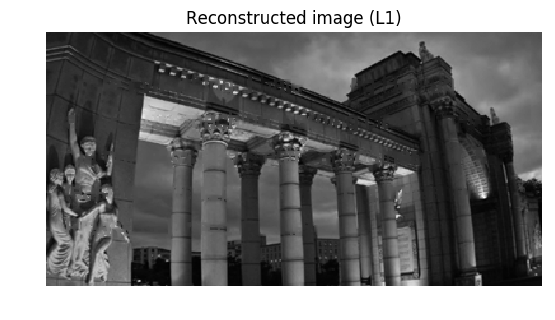


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -4.641e-14  +4.860e-13  +3e+05  9e-01  3e-02  1e+00  8e-01    ---    ---    1  3  - |  -  - 
 1  +4.654e+02  +4.654e+02  +4e+04  2e-01  4e-03  2e-01  1e-01  0.8584  2e-02   3  3  4 |  0  0
 2  +2.001e+03  +2.001e+03  +1e+04  2e-02  1e-03  4e-02  4e-02  0.7570  5e-02   2  2  3 |  0  0
 3  +3.097e+03  +3.097e+03  +4e+03  5e-03  4e-04  2e-02  1e-02  0.6778  8e-02   3  2  3 |  0  0
 4  +3.616e+03  +3.616e+03  +2e+03  2e-03  2e-04  7e-03  7e-03  0.5811  1e-01   3  2  2 |  0  0
 5  +3.956e+03  +3.956e+03  +9e+02  8e-04  8e-05  3e-03  3e-03  0.6643  1e-01   3  2  2 |  0  0
 6  +4.123e+03  +4.123e+03  +4e+02  3e-04  3e-05  1e-03  1e-03  0.6577  1e-01   2  2  2 |  0  0
 7  +4.186e+03  +4.186e+03  +2e+02  1e-04  1e-05  6e-04  6e-04  0.6906  3e-01   2  2  2 |  0  0
 8  +4.227e+03  +4.227e+03  +6e+01  5e-05  5e-

In [17]:
using Convex, ECOS

x_unk = Variable(n_unknown);
obj = sum(abs( A_MATRIX*x_unk + B_MATRIX ));
problem = minimize(obj);
solve!(problem, ECOSSolver())
x_unknown = evaluate(x_unk);

X_recon_L1 = reshape([Z_known Z_unknown]*[x_known; x_unknown], m, n);

figure();
imshow(X_recon_L1, cmap="gray");
title("Reconstructed image (L1)");
axis("off");

Now compare your reconstructed images with the clean original image. 

Can you tell the difference?

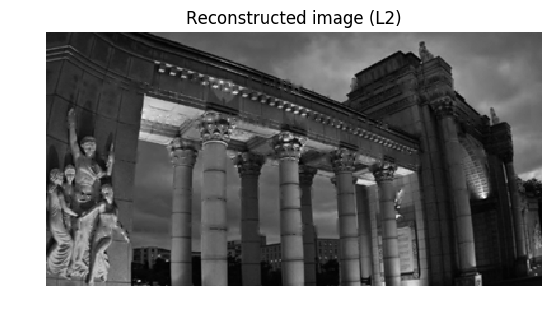

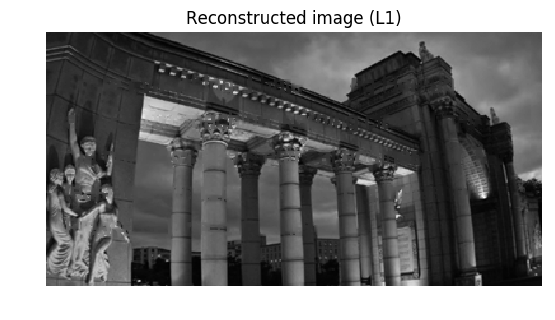

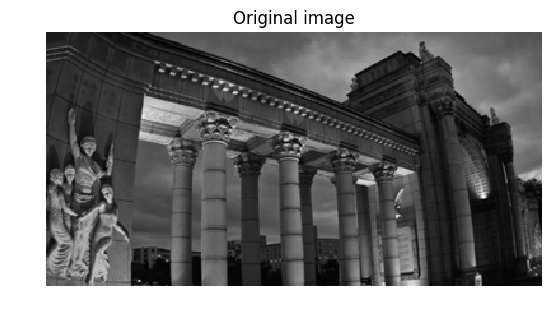

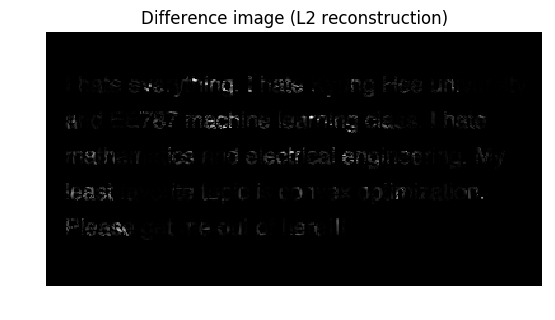

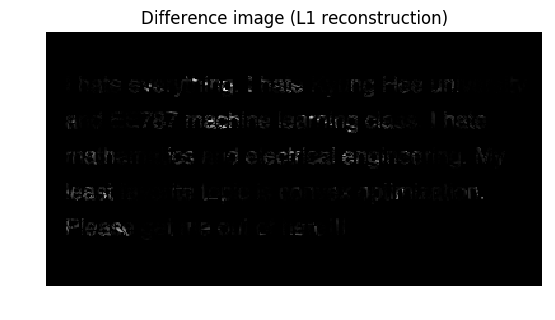

In [18]:
using Images, FileIO

X_clean = Float32.(Gray.(load("neo_bw.png")));

figure();
imshow(X_recon_L2, cmap="gray");
title("Reconstructed image (L2)");
axis("off");
figure();
imshow(X_recon_L1, cmap="gray");
title("Reconstructed image (L1)");
axis("off");
figure();
imshow(X_clean, cmap="gray");
title("Original image");
axis("off");

figure();
imshow(abs(X_clean-X_recon_L2), cmap="gray");
title("Difference image (L2 reconstruction)");
axis("off");
figure();
imshow(abs(X_clean-X_recon_L1), cmap="gray");
title("Difference image (L1 reconstruction)");
axis("off");
